<a href="https://colab.research.google.com/github/manan-garg/Automated_Trend_Analysis_with_NER/blob/main/Automated_Trend_Analysis_with_NER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement:

Twitter aims to enhance its understanding of trends and topics by automatically tagging and analyzing tweets. This approach eliminates the reliance on user-generated hashtags, as many users either omit them or use incorrect or misspelled tags.
By developing models for Named Entity Recognition (NER), Twitter aims to accurately identify and classify important content within tweets.
NER is a crucial component of information extraction that focuses on locating and recognizing named entities.
The task at hand involves training models that are capable of accurately identifying and classifying different named entities.



# 1. Import Libraries

In [ ]:
!pip install tensorflow_addons
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 28.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 40.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import tensorflow as tf
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import gensim.downloader as api
import numpy as np
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed, Bidirectional
from tensorflow_addons.layers import CRF
from tensorflow_addons.losses import SigmoidFocalCrossEntropy
from tensorflow_addons.optimizers import AdamW
from keras.models import Model
from transformers import AutoConfig, TFAutoModelForTokenClassification
from transformers import AutoTokenizer
from pprint import pprint

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# 2. Set Options

In [ ]:
warnings.simplefilter('ignore')
pd.set_option("display.max_columns", None)
pd.options.display.float_format = '{:.2f}'.format
sns.set_style('white')

# 3. Load Dataset

## 3.1 Downloading Dataset

## 3.2 Reading Train Dataset

In [ ]:
with open('wnut 16.txt.conll', 'r') as file:
    # Ignoring the final line since it is expected to be empty.
    lines = [line[:-1].split() for line in file]
train_dataset=[]
start = 0
for end, parts in enumerate(lines):
    if not parts:
        sample = []
        for token, tag in lines[start:end]:
            sample.append((token, tag))
        train_dataset.append(sample)
        start = end + 1
if start < end:
    train_dataset.append(lines[start:end])

### 3.2.1 Structure of Train Data

In [ ]:
train_dataset[0]

[('@SammieLynnsMom', 'O'),
 ('@tg10781', 'O'),
 ('they', 'O'),
 ('will', 'O'),
 ('be', 'O'),
 ('all', 'O'),
 ('done', 'O'),
 ('by', 'O'),
 ('Sunday', 'O'),
 ('trust', 'O'),
 ('me', 'O'),
 ('*wink*', 'O')]

## 3.3 Reading Test Dataset

In [ ]:
with open('wnut 16test.txt.conll', 'r') as file:
    # Ignoring the final line since it is expected to be empty.
    lines = [line[:-1].split() for line in file]
test_dataset=[]
start = 0
for end, parts in enumerate(lines):
    if not parts:
        sample = []
        for token, tag in lines[start:end]:
            sample.append((token, tag))
        test_dataset.append(sample)
        start = end + 1
if start < end:
    test_dataset.append(lines[start:end])

### 3.3.1 Structure of Test Data

In [ ]:
test_dataset[0]

[('New', 'B-other'),
 ('Orleans', 'I-other'),
 ('Mother', 'I-other'),
 ("'s", 'I-other'),
 ('Day', 'I-other'),
 ('Parade', 'I-other'),
 ('shooting', 'O'),
 ('.', 'O'),
 ('One', 'O'),
 ('of', 'O'),
 ('the', 'O'),
 ('people', 'O'),
 ('hurt', 'O'),
 ('was', 'O'),
 ('a', 'O'),
 ('10-year-old', 'O'),
 ('girl', 'O'),
 ('.', 'O'),
 ('WHAT', 'O'),
 ('THE', 'O'),
 ('HELL', 'O'),
 ('IS', 'O'),
 ('WRONG', 'O'),
 ('WITH', 'O'),
 ('PEOPLE', 'O'),
 ('?', 'O')]

# 4. Exploratory Data Analysis

## 4.1 Tags

In [ ]:
# get all the unique tags from dataset
unique_tags = set()
for sentence in (train_dataset + test_dataset):
    for token, tag in sentence:
        unique_tags.add(tag)
tags = sorted(unique_tags) + ['None'] # 'None' is used for blank token.
print(tags)

['B-company', 'B-facility', 'B-geo-loc', 'B-movie', 'B-musicartist', 'B-other', 'B-person', 'B-product', 'B-sportsteam', 'B-tvshow', 'I-company', 'I-facility', 'I-geo-loc', 'I-movie', 'I-musicartist', 'I-other', 'I-person', 'I-product', 'I-sportsteam', 'I-tvshow', 'O', 'None']


In [ ]:
# Determining the count of tokens associated with a specific tag in train dataset
token_counts = {}
for tag in tags:
    token_counts[tag] = 0
    for sentence in train_dataset:
        for data_token, data_tag in sentence:
            if data_tag == tag:
                token_counts[tag]+=1

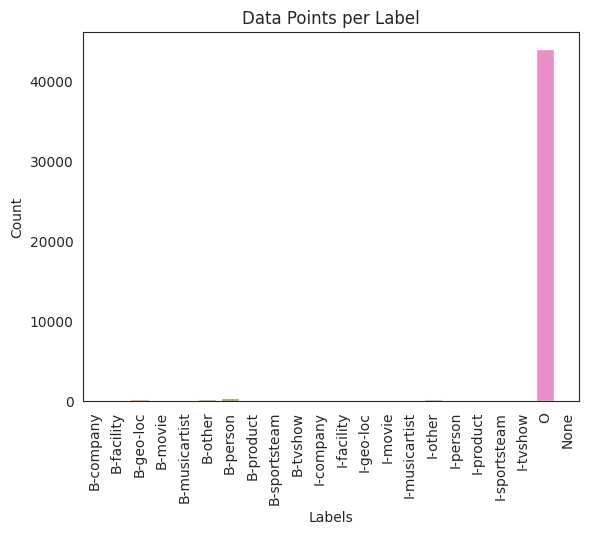

In [ ]:
# Create a DataFrame from the token_counts dictionary
token_tag_df = pd.DataFrame({'Label': token_counts.keys(), 'Count': token_counts.values()})

# Plot the bar chart
sns.barplot(x='Label', y='Count', data=token_tag_df)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Data Points per Label')
plt.xticks(rotation=90)
plt.show()

Since there are only a few annotations per sentence, it is common to have a high number of "other" fields. Let's exclude the O tag and analyze the distribution of the remaining tags.

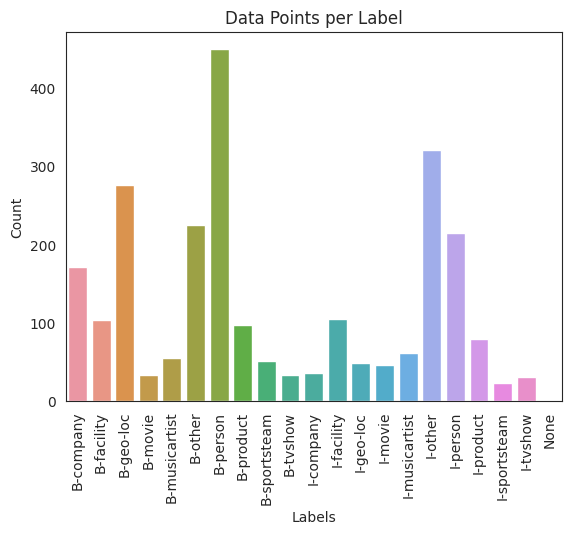

In [ ]:
# Removing 'O'
token_counts.pop('O')

# Create a DataFrame from the token_counts dictionary
token_tag_df = pd.DataFrame({'Label': token_counts.keys(), 'Count': token_counts.values()})

# Plot the bar chart
sns.barplot(x='Label', y='Count', data=token_tag_df)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Data Points per Label')
plt.xticks(rotation=90)
plt.show()

# 5. Data preprocessing

## 5.1 Combining Train and Test Dataset

In [ ]:
total_dataset = train_dataset
total_dataset.extend(test_dataset)

## 5.2 Vocabulary Size

In [ ]:
vocab_counts = defaultdict(int)
for sentence in total_dataset:
    for token,tag in sentence:
        vocab_counts[token]+=1
vocab_size = len(vocab_counts.items())
print(vocab_size)

25382


## 5.3 Maximum Sequence Length

In [ ]:
max_seq_len = 0

for sentence in total_dataset:
    max_seq_len = max(max_seq_len, len(sentence))
print(max_seq_len)

39


# 6. Training a LSTM + CRF Model

## 6.1 Using a word2vec model to initialize embeddings

In [ ]:
# Loading the Gensim model for word2vec.
word2vec_model = api.load("glove-twitter-200")
embedding_dimension = 200

# collecting tokens per sentence
tokens = []
for sentence in total_dataset:
    sentence_token=[]
    for token,tag in sentence:
        sentence_token.append(token)
    tokens.append(sentence_token)

[==================================================] 100.0% 758.5/758.5MB downloaded


## 6.2 Tokenizer for Model

In [ ]:
crf_tokenizer_instance = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size, lower=True)
crf_tokenizer_instance.fit_on_texts(tokens)

In [ ]:
num_tokens = len(crf_tokenizer_instance.word_index) + 1
found_hits = 0
missed_hits = 0
word_set = set(word2vec_model.key_to_index.keys())

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dimension))
missed_words = [None] * num_tokens

for index, word in enumerate(crf_tokenizer_instance.word_index, start=1):
    if word in word_set:
        embedding_matrix[index] = word2vec_model.get_vector(word)
        found_hits += 1
    else:
        missed_words[index] = word
        missed_hits += 1

print("Converted words:{} and misses:{}".format(found_hits, missed_hits))

Converted words:11495 and misses:10438


## 6.3 Preparing Dataset

In [ ]:
# creating parameters
label_to_index = {tag: i for i, tag in enumerate(tags)}
index_to_label = {i: tag for i, tag in enumerate(tags)}

In [ ]:
# function to prepare dataset
def prepare_dataset(samples, max_seq_len, label_to_index, tokenizer):
    dataset = {'input_sequences': [], 'label_sequences': []}

    for sample in samples:
        # Extracting input tokens and output labels
        input_tokens = [x[0] for x in sample]
        output_labels = [x[1] for x in sample]

        # Tokenizing input tokens
        tokenized_inputs = tokenizer.texts_to_sequences([input_tokens])[0]

        # Padding input sequences
        padded_inputs = [tokenized_inputs[i] if i < len(tokenized_inputs) else 0 for i in range(max_seq_len)]

        # Initializing labels as one-hot encoded vectors
        num_labels = len(label_to_index)
        padded_labels = [[0] * num_labels for _ in range(max_seq_len)]
        for i in range(len(output_labels)):
            label_id = label_to_index[output_labels[i]]
            padded_labels[i][label_id] = 1

        # Adding padded input sequences and labels to the dataset
        dataset['input_sequences'].append(padded_inputs)
        dataset['label_sequences'].append(padded_labels)

    return np.array(dataset['input_sequences']), np.array(dataset['label_sequences'])

In [ ]:
# preparing dataset
updated_train_sentences, updated_train_labels = prepare_dataset(train_dataset, max_seq_len,
                                                                label_to_index, crf_tokenizer_instance)
updated_test_sentences, updated_test_labels = prepare_dataset(test_dataset, max_seq_len,
                                                              label_to_index, crf_tokenizer_instance)

## 6.4 Building Model

In [ ]:
# Model definition
input_seq = Input(shape=(max_seq_len,))

# Get embeddings
embeddings = Embedding(input_dim=embedding_matrix.shape[0],
                        output_dim=embedding_dimension,
                        input_length=max_seq_len,
                        mask_zero=True,
                        embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix)
                        )(input_seq)

# Variational biLSTM
lstm_output = Bidirectional(LSTM(units=50, return_sequences=True))(embeddings)

# Stacking
stacked_lstm_output = Bidirectional(LSTM(units=50, return_sequences=True))(lstm_output)

# Adding more non-linearity
dense_out = TimeDistributed(Dense(25, activation="relu"))(stacked_lstm_output)

# CRF layer
crf = CRF(len(tags), name='crf')
predicted_sequence, potentials, sequence_length, crf_kernel = crf(dense_out)

model = Model(input_seq, potentials)
model.compile(optimizer=AdamW(weight_decay=0.001), loss=SigmoidFocalCrossEntropy())

In [ ]:
# Checkpointing
save_model_callback = tf.keras.callbacks.ModelCheckpoint(filepath='twitter_ner_crf_nlp.h5',
                                                         monitor='val_loss',
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         verbose=1
                                                         )

# Early stopping
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=10)

callbacks = [save_model_callback, early_stopping_callback]

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 39)]              0         
                                                                 
 embedding (Embedding)       (None, 39, 200)           4386800   
                                                                 
 bidirectional (Bidirectiona  (None, 39, 100)          100400    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 39, 100)          60400     
 nal)                                                            
                                                                 
 time_distributed (TimeDistr  (None, 39, 25)           2525      
 ibuted)                                                         
                                                             

## 6.5 Training

In [ ]:
# Training
model.fit(updated_train_sentences, updated_train_labels,
          validation_data = (updated_test_sentences, updated_test_labels),
          epochs = 300,
          callbacks  = callbacks,
          shuffle=True)

Epoch 1/300


194/196 [============================>.] - ETA: 0s - loss: 0.0751
Epoch 1: val_loss improved from inf to 0.03965, saving model to twitter_ner_crf_nlp.h5
196/196 [==============================] - 32s 60ms/step - loss: 0.0750 - val_loss: 0.0397
Epoch 2/300
195/196 [============================>.] - ETA: 0s - loss: 0.0378
Epoch 2: val_loss improved from 0.03965 to 0.03444, saving model to twitter_ner_crf_nlp.h5
196/196 [==============================] - 5s 28ms/step - loss: 0.0378 - val_loss: 0.0344
Epoch 3/300
196/196 [==============================] - ETA: 0s - loss: 0.0279
Epoch 3: val_loss improved from 0.03444 to 0.02623, saving model to twitter_ner_crf_nlp.h5
196/196 [==============================] - 5s 28ms/step - loss: 0.0279 - val_loss: 0.0262
Epoch 4/300
195/196 [============================>.] - ETA: 0s - loss: 0.0213
Epoch 4: val_loss improved from 0.02623 to 0.02043, saving model to twitter_ner_crf_nlp.h5
196/196 [==============================] - 7s 34ms/step - loss: 0.021

## 6.6 Testing

In [ ]:
model.load_weights('twitter_ner_crf_nlp.h5')

In [ ]:
# getting the best model
lstm_crf_model = tf.keras.Model(inputs=model.input, outputs=[model.output,
                                                             model.get_layer('crf').output,
                                                             model.input])

In [ ]:
# Batch the dataset
batched_test_set = tf.data.Dataset.from_tensor_slices((updated_test_sentences, updated_test_labels)).batch(32)

average_accuracy = 0
# Iterate through batches
for batch_input_sequences, batch_label_sequences in batched_test_set:
    predicted_sequences, _, _, _ = lstm_crf_model(batch_input_sequences)[1]
    accuracy_metric = tf.keras.metrics.Accuracy()
    true_labels = batch_label_sequences
    predicted_labels = predicted_sequences
    true_indices = tf.argmax(true_labels, axis=-1)
    average_accuracy += accuracy_metric(true_indices, predicted_labels).numpy().item()

average_accuracy /= len(batched_test_set)

In [ ]:
print("average accuracy of the model when evaluated on the test set: {}".format(average_accuracy))

average accuracy of the model when evaluated on the test set: 0.9908945181153037


# 7. Transformer model - BERT

## 7.1 Tokenizer for BERT

In [ ]:
bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

## 7.2 Understanding data after tokenization

In [ ]:
sample=train_dataset[10] # Random tokenized sample
for token, tag in sample:
    for subtoken in bert_tokenizer(token)['input_ids']:
        print(token,subtoken)

RT 101
RT 19387
RT 102
@Hatshepsutely 101
@Hatshepsutely 1030
@Hatshepsutely 16717
@Hatshepsutely 5369
@Hatshepsutely 4523
@Hatshepsutely 10421
@Hatshepsutely 2135
@Hatshepsutely 102
: 101
: 1024
: 102
@adamlambert 101
@adamlambert 1030
@adamlambert 4205
@adamlambert 10278
@adamlambert 8296
@adamlambert 102
please 101
please 3531
please 102
, 101
, 1010
, 102
oh 101
oh 2821
oh 102
please 101
please 3531
please 102
wear 101
wear 4929
wear 102
the 101
the 1996
the 102
infamous 101
infamous 14429
infamous 102
beach 101
beach 3509
beach 102
hat 101
hat 6045
hat 102
tonight 101
tonight 3892
tonight 102
during 101
during 2076
during 102
your 101
your 2115
your 102
encore 101
encore 19493
encore 102
( 101
( 1006
( 102
in 101
in 1999
in 102
lieu 101
lieu 22470
lieu 102
of 101
of 1997
of 102
a 101
a 1037
a 102
rasta 101
rasta 20710
rasta 2696
rasta 102
wig) 101
wig) 24405
wig) 1007
wig) 102
. 101
. 1012
. 102
&lt; 101
&lt; 1004
&lt; 8318
&lt; 1025
&lt; 102
3333 101
3333 21211
3333 2509
3333 102

The tokenizer adds the tokens with IDs 101 and 102 at the start and end of the token sequence for encoding purposes. These tokens serve as special tokens to indicate the beginning and end of a sequence, respectively. By adding these tokens, the model can learn to distinguish the start and end of input sequences during training and inference.

## 7.3 Preparing Dataset

In [ ]:
def prepare_dataset_bert(samples, label_to_index):
    tokenized_samples = []
    max_seq_len = 0

    for sample in samples:
        subtoken_seq = []
        for token, tag in sample:
            for subtoken in bert_tokenizer(token.lower())['input_ids'][1:-1]:
                subtoken_seq.append((subtoken, tag))
        tokenized_sample = [(3, 'O')] + subtoken_seq + [(4, 'O')]
        max_seq_len = max(max_seq_len, len(tokenized_sample))
        tokenized_samples.append(tokenized_sample)

    # Subtokens
    input_ids = np.zeros((len(samples), max_seq_len), dtype=np.int32)

    # Masks
    input_masks = np.zeros((len(samples), max_seq_len), dtype=np.int32)

    # Labels
    labels = np.zeros((len(samples), max_seq_len), dtype=np.int32)

    for i, tokenized_sample in enumerate(tokenized_samples):
        for j in range(len(tokenized_sample)):
            input_masks[i, j] = 1  # Set mask to 1 for valid tokens
        for j, (subtoken_id, tag) in enumerate(tokenized_sample):
            input_ids[i, j] = subtoken_id  # Assign subtoken ID
            labels[i, j] = label_to_index[tag]  # Assign label ID

    return (input_ids, input_masks), labels

In [ ]:
X_train, y_train = prepare_dataset_bert(train_dataset, label_to_index)
X_test, y_test = prepare_dataset_bert(test_dataset, label_to_index)

## 7.4 Loading BERT Model

In [ ]:
bert_config = AutoConfig.from_pretrained('bert-base-uncased', num_labels=len(tags),
                                         id2tag=index_to_label, tag2id=label_to_index)
bert_model = TFAutoModelForTokenClassification.from_pretrained('bert-base-uncased', config=bert_config)
bert_model.summary()

All model checkpoint layers were used when initializing TFBertForTokenClassification.

Some layers of TFBertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_token_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108891648 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  16918     
                                                                 
Total params: 108,908,566
Trainable params: 108,908,566
Non-trainable params: 0
_________________________________________________________________


## 7.5 Training

In [ ]:
bert_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
    )
bert_history = bert_model.fit(
                          X_train,
                          y_train,
                          validation_split=0.2,
                          epochs=10,
                          batch_size=32
                          )

Epoch 1/10
157/157 [==============================] - 239s 1s/step - loss: 0.1673 - accuracy: 0.9644 - val_loss: 0.0921 - val_accuracy: 0.9845
Epoch 2/10
157/157 [==============================] - 185s 1s/step - loss: 0.0592 - accuracy: 0.9882 - val_loss: 0.0539 - val_accuracy: 0.9871
Epoch 3/10
157/157 [==============================] - 187s 1s/step - loss: 0.0357 - accuracy: 0.9911 - val_loss: 0.0447 - val_accuracy: 0.9886
Epoch 4/10
157/157 [==============================] - 187s 1s/step - loss: 0.0240 - accuracy: 0.9936 - val_loss: 0.0444 - val_accuracy: 0.9904
Epoch 5/10
157/157 [==============================] - 178s 1s/step - loss: 0.0159 - accuracy: 0.9958 - val_loss: 0.0405 - val_accuracy: 0.9909
Epoch 6/10
157/157 [==============================] - 185s 1s/step - loss: 0.0105 - accuracy: 0.9973 - val_loss: 0.0409 - val_accuracy: 0.9908
Epoch 7/10
157/157 [==============================] - 185s 1s/step - loss: 0.0079 - accuracy: 0.9981 - val_loss: 0.0438 - val_accuracy: 0.9902

## 7.6 Testing

In [ ]:
y_probs = bert_model.predict(X_test)[0]
bert_predictions = []

for sample, predictions in zip(test_dataset, y_probs):
    token_results = []
    i = 1

    for token, y_true in sample:
        # Extracting word tokens
        subtoken_count = len(bert_tokenizer(token.lower())['input_ids']) - 2

        # Extracting predictions
        pred_label = predictions[i:i+subtoken_count]
        i += subtoken_count

        # Get label of prediction
        y_pred = tags[np.argmax(np.sum(pred_label, axis=0))]
        token_results.append((token, y_true, y_pred))

    bert_predictions.append(token_results)

121/121 [==============================] - 46s 354ms/step


In [ ]:
print(bert_predictions)

[[('New', 'B-other', 'B-other'), ('Orleans', 'I-other', 'I-other'), ('Mother', 'I-other', 'I-other'), ("'s", 'I-other', 'I-other'), ('Day', 'I-other', 'I-other'), ('Parade', 'I-other', 'I-other'), ('shooting', 'O', 'O'), ('.', 'O', 'O'), ('One', 'O', 'O'), ('of', 'O', 'O'), ('the', 'O', 'O'), ('people', 'O', 'O'), ('hurt', 'O', 'O'), ('was', 'O', 'O'), ('a', 'O', 'O'), ('10-year-old', 'O', 'O'), ('girl', 'O', 'O'), ('.', 'O', 'O'), ('WHAT', 'O', 'O'), ('THE', 'O', 'O'), ('HELL', 'O', 'O'), ('IS', 'O', 'O'), ('WRONG', 'O', 'O'), ('WITH', 'O', 'O'), ('PEOPLE', 'O', 'O'), ('?', 'O', 'O')], [('RT', 'O', 'O'), ('@hxranspizza', 'O', 'O'), (':', 'O', 'O'), ('Going', 'O', 'O'), ('into', 'O', 'O'), ('school', 'O', 'O'), ('tomorrow', 'O', 'O'), ('like', 'O', 'O'), ('#KCA', 'O', 'O'), ('#Vote1DUK', 'O', 'O'), ('http://t.co/vvkoEEMjMX', 'O', 'O')], [('May', 'O', 'O'), ('e', 'O', 'O'), ('just', 'O', 'O'), ('a', 'O', 'O'), ('smile', 'O', 'O'), ('in', 'O', 'O'), ('your', 'O', 'O'), ('heart', 'O', 'O'

In [ ]:
bert_predictions_df = pd.DataFrame([ele for token in bert_predictions for ele in token],
                                   columns = ['Tokens', 'True Tag', 'Predicted Tag'])
bert_predictions_df.head(10)

,Tokens,True Tag,Predicted Tag
0,New,B-other,B-other
1,Orleans,I-other,I-other
2,Mother,I-other,I-other
3,'s,I-other,I-other
4,Day,I-other,I-other
5,Parade,I-other,I-other
6,shooting,O,O
7,.,O,O
8,One,O,O
9,of,O,O


## 7.7 Saving Model

In [ ]:
bert_model.save_pretrained("BERT_pretrained")

# 8. Checking on own sentences

In [ ]:
input_sentence = "John Smith visited New York City to meet Microsoft employees and tour their headquarters. He bought an iPhone, listened to Taylor Swift's new album, watched a Marvel movie, cheered for the Los Angeles Lakers, and binge-watched a popular TV show."

## 8.1 Checking on BERT

In [ ]:
# tokenization
input_sentence_tokens = bert_tokenizer(input_sentence.split(' '))['input_ids']
bert_tokens = [3]
for token in input_sentence_tokens:
    bert_tokens.extend(token[1:-1])
bert_tokens.extend([4])

bert_logits = bert_model.predict([bert_tokens], verbose=0).logits

# Obtaining labels corresponding to tokens
sentence_tokens = input_sentence.lower().split(" ")
bert_check_result = []
i = 1
for token in sentence_tokens:
    subtoken_count = len(bert_tokenizer(token)['input_ids']) - 2
    pred = bert_logits[0][i:i+subtoken_count]
    i += subtoken_count
    y_pred = index_to_label[np.argmax(np.sum(pred, axis=0))]
    bert_check_result.append((token, y_pred))

# result
bert_check_result

[('john', 'B-person'),
 ('smith', 'I-person'),
 ('visited', 'O'),
 ('new', 'B-geo-loc'),
 ('york', 'I-geo-loc'),
 ('city', 'I-geo-loc'),
 ('to', 'O'),
 ('meet', 'O'),
 ('microsoft', 'B-company'),
 ('employees', 'O'),
 ('and', 'O'),
 ('tour', 'O'),
 ('their', 'O'),
 ('headquarters.', 'O'),
 ('he', 'O'),
 ('bought', 'O'),
 ('an', 'O'),
 ('iphone,', 'O'),
 ('listened', 'O'),
 ('to', 'O'),
 ('taylor', 'B-person'),
 ("swift's", 'O'),
 ('new', 'O'),
 ('album,', 'O'),
 ('watched', 'O'),
 ('a', 'O'),
 ('marvel', 'B-company'),
 ('movie,', 'O'),
 ('cheered', 'O'),
 ('for', 'O'),
 ('the', 'O'),
 ('los', 'B-sportsteam'),
 ('angeles', 'I-sportsteam'),
 ('lakers,', 'O'),
 ('and', 'O'),
 ('binge-watched', 'O'),
 ('a', 'O'),
 ('popular', 'O'),
 ('tv', 'O'),
 ('show.', 'O')]

## 8.2 Checking on LSTM + CRF

In [ ]:
# tokenization
lstm_crf_tokens = crf_tokenizer_instance.texts_to_sequences([input_sentence])

lstm_crf_padded_tokens=[[]]
for i in range(39):
    if i < len(lstm_crf_tokens[0]):
        lstm_crf_padded_tokens[0].append(lstm_crf_tokens[0][i])
    else:
        lstm_crf_padded_tokens[0].append(0)

lstm_crf_preds, _, _, _ = lstm_crf_model.predict(lstm_crf_padded_tokens, verbose=0)[1]

# Obtaining labels corresponding to tokens
lstm_crf_result = []
for i in lstm_crf_preds[0]:
    lstm_crf_result.append(index_to_label[i])

word_tokens = []
for i in lstm_crf_padded_tokens[0]:
    word_tokens.append(crf_tokenizer_instance.sequences_to_texts([[i]])[0])

# result
pprint(list(zip(word_tokens[:len(lstm_crf_tokens[0])], lstm_crf_result[:len(lstm_crf_tokens[0])])))

[('john', 'B-person'),
 ('smith', 'I-person'),
 ('visited', 'O'),
 ('new', 'B-other'),
 ('york', 'I-geo-loc'),
 ('city', 'O'),
 ('to', 'O'),
 ('meet', 'O'),
 ('microsoft', 'B-company'),
 ('employees', 'O'),
 ('and', 'O'),
 ('tour', 'O'),
 ('their', 'O'),
 ('he', 'O'),
 ('bought', 'O'),
 ('an', 'O'),
 ('iphone', 'O'),
 ('listened', 'O'),
 ('to', 'O'),
 ('taylor', 'B-musicartist'),
 ('new', 'O'),
 ('album', 'O'),
 ('watched', 'O'),
 ('a', 'O'),
 ('marvel', 'B-other'),
 ('movie', 'I-musicartist'),
 ('for', 'None'),
 ('the', 'B-facility'),
 ('los', 'B-other'),
 ('angeles', 'I-geo-loc'),
 ('and', 'O'),
 ('watched', 'O'),
 ('a', 'O'),
 ('popular', 'O'),
 ('tv', 'O'),
 ('show', 'O')]
